In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from LoadData import loaddata, filter_zeroes

simulation_names = ['Eagle', 'Illustris', 'IllustrisTNG', 'Mufasa', 'Simba', 'SC-Sam', 'UniverseMachine', 'Fire-2', 'Marvel_JL']
data = loaddata(simulation_names)

inputHistories = np.array([element[0] for element in data])
mass_presentsfr = np.array([element[1] for element in data])

filtered_inputHistories, filtered_mass_presentsfr = filter_zeroes(inputHistories, mass_presentsfr)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(filtered_inputHistories, filtered_mass_presentsfr, test_size=0.2, random_state=42)

# Normalize the star formation histories
X_train = [(sfh / (np.trapz(sfh)) * 500) for sfh in X_train]  # Normalize SFH
X_test = [(sfh / (np.trapz(sfh)) * 500) for sfh in X_test]    # Normalize SFH

X_train = np.array(X_train)
X_test = np.array(X_test)

# Further split the training data into 80% (64%) training and 20% (16%) validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

device = "cpu"
print(f"Using {device} device")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32) 
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

Using cpu device


**The first 100 SFHs:**

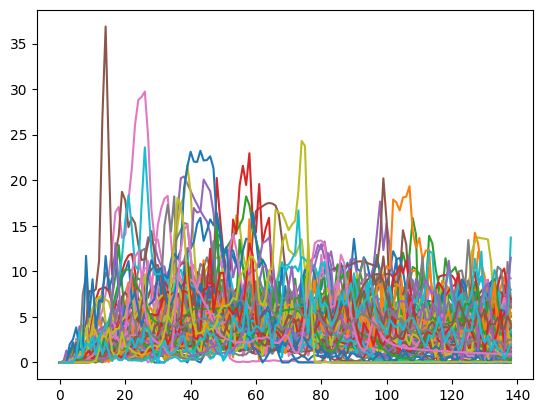

In [3]:
for i in range(100):
    plt.plot(X_train[i])

In [6]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Define the neural network
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=4, padding=1)  
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=4, padding=1)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=1)
        self.conv4 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=1)  
        self.pool = nn.MaxPool1d(2, 2)  
        self.fc1 = nn.Linear(16 * 7, 64)  
        self.fc2 = nn.Linear(64, 32)
        
        # Decoder
        self.fc3 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(64, 16 * 7)
        self.deconv1 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=4, stride=2)
        self.deconv2 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=4, stride=2)
        self.deconv3 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=3, stride=2)
        self.deconv4 = nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=3, stride=2)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))  
        x = x.view(-1, 16 * 7)  # Matching new dimensions after convolutions and pooling
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = x.view(-1, 16, 7)
        x = torch.relu(self.deconv1(x))
        x = torch.relu(self.deconv2(x))
        x = torch.relu(self.deconv3(x))
        x = torch.relu(self.deconv4(x))
        return x

# Create the model instance
AE = ConvAutoencoder().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Assuming regression task with MSE loss
optimizer = optim.Adam(AE.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)

# Create a DataLoader for batch processing
dataset = TensorDataset(X_train_tensor.unsqueeze(1), y_train_tensor)
dataloader = DataLoader(dataset, batch_size=200, shuffle=True)

val_dataset = TensorDataset(X_val_tensor.unsqueeze(1), y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=200, shuffle=False)

In [5]:
print(AE)

ConvAutoencoder(
  (conv1): Conv1d(1, 16, kernel_size=(4,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 16, kernel_size=(4,), stride=(1,), padding=(1,))
  (conv3): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(1,))
  (conv4): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=112, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=112, bias=True)
  (deconv1): ConvTranspose1d(16, 16, kernel_size=(4,), stride=(2,))
  (deconv2): ConvTranspose1d(16, 16, kernel_size=(4,), stride=(2,))
  (deconv3): ConvTranspose1d(16, 16, kernel_size=(3,), stride=(2,))
  (deconv4): ConvTranspose1d(16, 1, kernel_size=(3,), stride=(2,))
)


In [7]:
# Training loop
num_epochs = 500 
losses = [] # To store training losses
val_losses = []  # To store validation losses

for epoch in range(num_epochs):
    loss = 0.0
    for data in dataloader:
        inputs, _ = data
        optimizer.zero_grad()
        outputs = AE(inputs)
        curr_loss = criterion(outputs, inputs) # Comparing output to input for autoencoder
        curr_loss.backward()
        optimizer.step()
        loss += curr_loss.item()

    loss /= len(dataloader)
    losses.append(loss)
    
    AE.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_dataloader:
            val_inputs, _ = data
            val_outputs = AE(val_inputs)
            val_loss += criterion(val_outputs, val_inputs).item() # Comparing validation output and input
    
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    

    if epoch % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')
    # tell scheduler to consider updating learning rate
    scheduler.step()

print('Training complete')

Epoch [1/500], Training Loss: 5.0628, Val Loss: 3.6091
Epoch [11/500], Training Loss: 1.8643, Val Loss: 1.8401
Epoch [21/500], Training Loss: 1.6722, Val Loss: 1.6690
Epoch [31/500], Training Loss: 1.5723, Val Loss: 1.5773
Epoch [41/500], Training Loss: 1.4809, Val Loss: 1.4787
Epoch [51/500], Training Loss: 1.4541, Val Loss: 1.4581
Epoch [61/500], Training Loss: 1.4057, Val Loss: 1.3912
Epoch [71/500], Training Loss: 1.3371, Val Loss: 1.3425
Epoch [81/500], Training Loss: 1.3520, Val Loss: 1.3120
Epoch [91/500], Training Loss: 1.2632, Val Loss: 1.2924
Epoch [101/500], Training Loss: 1.2385, Val Loss: 1.2581
Epoch [111/500], Training Loss: 1.2489, Val Loss: 1.2336
Epoch [121/500], Training Loss: 1.2119, Val Loss: 1.2262
Epoch [131/500], Training Loss: 1.1906, Val Loss: 1.2009
Epoch [141/500], Training Loss: 1.1744, Val Loss: 1.1954
Epoch [151/500], Training Loss: 1.1599, Val Loss: 1.1769
Epoch [161/500], Training Loss: 1.1685, Val Loss: 1.1877
Epoch [171/500], Training Loss: 1.1384, Va

In [9]:
AE = torch.load('AE Models/torch0.963autoencodervalmodel.pth')
print(AE)

ConvAutoencoder(
  (conv1): Conv1d(1, 16, kernel_size=(4,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 16, kernel_size=(4,), stride=(1,), padding=(1,))
  (conv3): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(1,))
  (conv4): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=112, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=112, bias=True)
  (deconv1): ConvTranspose1d(16, 16, kernel_size=(4,), stride=(2,))
  (deconv2): ConvTranspose1d(16, 16, kernel_size=(4,), stride=(2,))
  (deconv3): ConvTranspose1d(16, 16, kernel_size=(3,), stride=(2,))
  (deconv4): ConvTranspose1d(16, 1, kernel_size=(3,), stride=(2,))
)


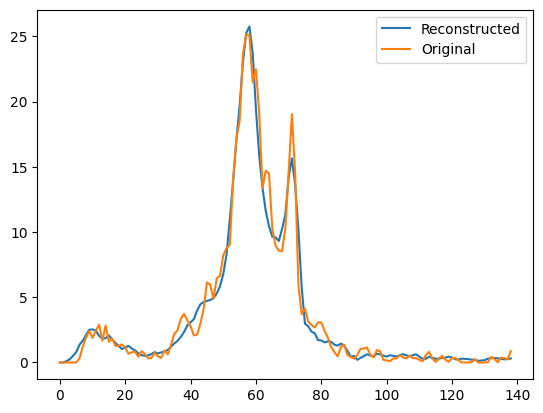

In [10]:
i = 2132
plt.plot(AE(X_val_tensor[i].unsqueeze(0).unsqueeze(0))[0][0].detach().numpy())
plt.plot(X_val_tensor[i].unsqueeze(0).unsqueeze(0)[0][0].detach().numpy())
plt.legend(['Reconstructed', 'Original'])

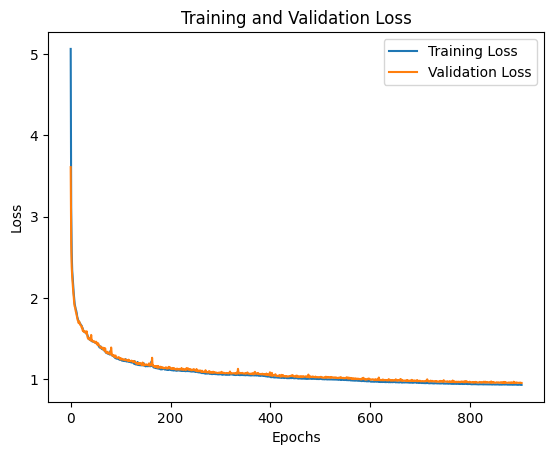

In [36]:
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [37]:
torch.save(AE, 'AE Models/torch0.963autoencodervalmodel.pth')

In [15]:
generated_SFHs = AE(X_test_tensor.unsqueeze(1))
real_SFHs = X_test_tensor.unsqueeze(1)

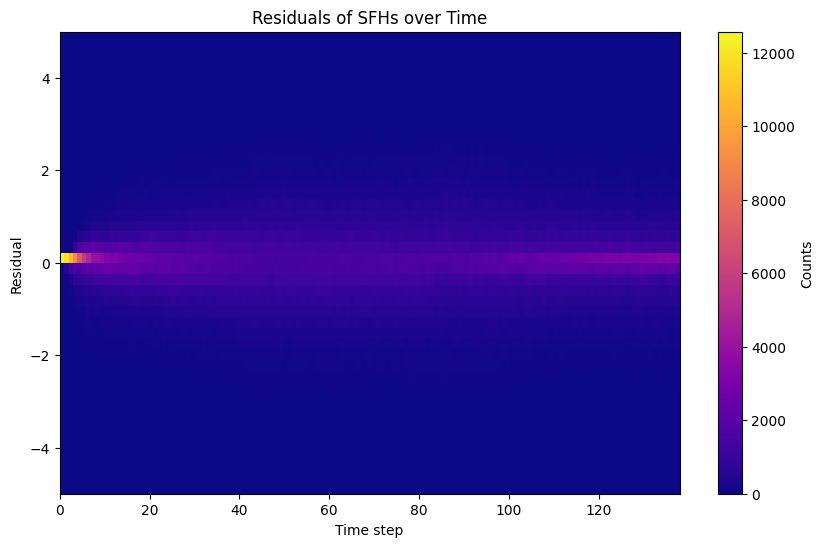

In [40]:
# Calculate residuals
residuals = (generated_SFHs - real_SFHs).detach().numpy().squeeze()

# Create time axis
time_axis = np.tile(np.arange(residuals.shape[1]), residuals.shape[0])

# Flatten the residuals
residuals_flat = residuals.flatten()

# Create a 2D histogram
plt.figure(figsize=(10, 6))
plt.hist2d(time_axis, residuals_flat, bins=[139, 300], cmap='plasma')
plt.ylim(-5,5)
plt.colorbar(label='Counts')
plt.xlabel('Time step')
plt.ylabel('Residual')
plt.title('Residuals of SFHs over Time')
plt.show()

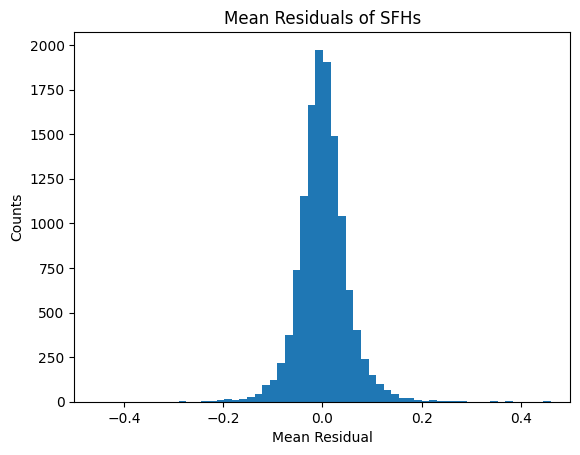

In [38]:
plt.hist([np.mean(residual) for residual in residuals], bins=150)
plt.xlabel('Mean Residual')
plt.ylabel('Counts')
plt.title('Mean Residuals of SFHs')
plt.xlim(-0.5, 0.5)
plt.show()